In [1]:
#import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

import requests
import gmaps
import os
from pprint import pprint

#import api key
from api_keys import g_key

In [2]:
#create dataframe from csv of breweries, courtesy of OpenBreweryDB (https://github.com/openbrewerydb/openbrewerydb)
brews_df = pd.read_csv ('openbrewerydb.csv')

#isolate breweries in the state of georgia
ga_brews_df = brews_df.loc [brews_df['state'] == 'Georgia', :]

#can exclude breweries in planning, or we can analyze them too
# ga_brews_df = ga_brews_df.loc [ga_brews_df['brewery_type'] != 'planning', :]

ga_brews_df.head()
# ga_brews_df

,id,name,brewery_type,street,city,state,postal_code,website_url,phone,created_at,updated_at,country,longitude,latitude,tags
2077,millercoors-brewing-co-albany,MillerCoors Brewing Co - Albany,large,405 Cordele Rd,Albany,Georgia,31705-2109,NaN,NaN,2018-07-24 01:33:15.988112,2018-08-24 00:29:13.337065,United States,-84.082031,31.585493,NaN
2078,pretoria-fields-collective,Pretoria Fields Collective,micro,120 Pine Ave,Albany,Georgia,31701-2529,http://www.pretoriafields.com,2.295182e+09,2018-07-24 01:33:16.20317,2018-08-24 00:29:21.824512,United States,-84.149593,31.578583,NaN
2079,currahee-brewing-company,Currahee Brewing Company,micro,25 S Main St,Alpharetta,Georgia,30009,NaN,NaN,2018-07-24 01:33:15.618382,2018-08-24 00:29:02.040773,United States,-84.296783,34.071110,NaN
2080,jekyll-brewing,Jekyll Brewing,micro,2855 Marconi Dr Ste 350,Alpharetta,Georgia,30005-2051,http://www.jekyllbrewing.com,7.705969e+09,2018-07-24 01:33:15.884802,2018-08-24 00:29:09.789612,United States,-84.253664,34.081656,NaN
2081,southern-brewing-company,Southern Brewing Company,micro,231 Collins Industrial Blvd,Athens,Georgia,30601-1517,http://www.sobrewco.com,7.065487e+09,2018-07-24 01:33:16.426119,2018-08-24 00:29:29.429091,United States,-83.350023,33.981140,NaN


In [3]:
#analysis 1: comparing number of types of breweries

#gather frequency of types of breweries, display in dataframe
type_counts = ga_brews_df['brewery_type'].value_counts()

type_counts_df = pd.DataFrame (type_counts)
type_counts_df

,brewery_type
micro,46
brewpub,25
planning,24
regional,3
large,3
contract,2
proprietor,1


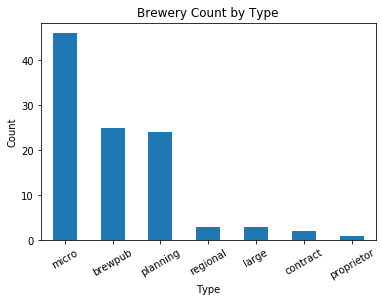

In [4]:
#eduardo
ax = type_counts_df.plot(kind='bar', title='Brewery Count by Type', legend=None)
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.set_xticklabels(type_counts_df.index, rotation=30)
plt.savefig('output/bar1.png')

C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


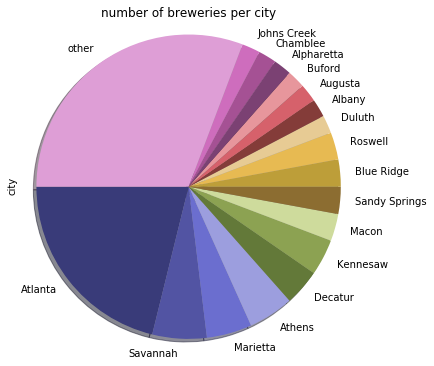

In [21]:
#analysis 2: cities/areas w/ the most breweries

#make sure that all cities are capitalized correctly so nothing is miscounted
ga_brews_df['city'] = ga_brews_df['city'].str.title()

#gather frequencies of these breweries per city, create dataframe
city_counts = ga_brews_df['city'].value_counts()
city_counts_df = pd.DataFrame (city_counts)

#divide cities w/ at least 2 breweries & cities w/ just 1
top_cities_df = city_counts_df.loc [city_counts_df['city'] > 1]
bottom_cities_df = city_counts_df.loc [city_counts_df['city'] == 1]

#total the cities' breweries, create new dataframe to append to top_cities_df
bottom_total = len(bottom_cities_df)
other_cities_df = pd.DataFrame ({'city': [bottom_total]},
                                index = ['other'])

top_cities_df = top_cities_df.append (other_cities_df)

# pretty pie chart
top_cities_df.plot.pie (y = 'city',
                        legend = False,
                        startangle = 180,
                        shadow = True,
                        figsize = (6,6),
                        colormap = "tab20b",
#                         autopct = "%1.1f%%",
                        title = 'number of breweries per city')

plt.axis ("equal")

#export png
plt.savefig ('output/city_pie_chart.png')

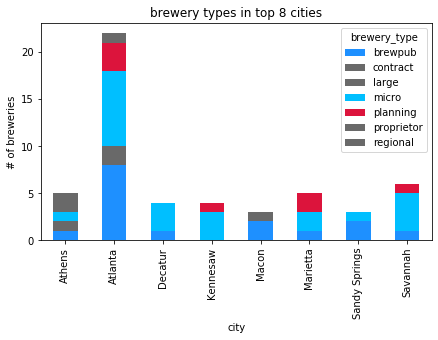

In [37]:
#stacked bar chart using city & type counts in previous 2 cells
stacked_data = ga_brews_df.loc [:, ('city', 'brewery_type')]

#create list of cities w/ only 1 brewery, designate city as 'other' for plotting purposes
# bottom_cities = bottom_cities_df.index

# for city in bottom_cities:
#     stacked_data.loc [stacked_data ['city'] == city, 'city'] = 'other'

#pull top 8 cities
top_cities = top_cities_df[0:8].index

#unfortunately couldn't get the loop to work
stacked_data_top = stacked_data.loc [(stacked_data ['city'] == top_cities[0])|
                                     (stacked_data ['city'] == top_cities[1])|
                                     (stacked_data ['city'] == top_cities[2])|
                                     (stacked_data ['city'] == top_cities[3])|
                                     (stacked_data ['city'] == top_cities[4])|
                                     (stacked_data ['city'] == top_cities[5])|
                                     (stacked_data ['city'] == top_cities[6])|
                                     (stacked_data ['city'] == top_cities[7]), :]
    
# group data by city & brewery type, unstack for plotting
stacked_data_groups = stacked_data.groupby(['city', 'brewery_type']).size().unstack()
stacked_data_groups = stacked_data_top.groupby(['city', 'brewery_type']).size().unstack()

#plot stacked bar chart
stacked_data_groups.plot.bar(stacked = True,
                             title = 'brewery types in top 8 cities',
                             color = ('dodgerblue', 'dimgrey', 'dimgrey', 'deepskyblue', 'crimson', 'dimgrey', 'dimgrey'),
                             figsize = (7, 4))
plt.ylabel ('# of breweries')

#export png
plt.savefig ('output/stacked_bar_chart.png')

In [7]:
#use locate fxn to isolate small production breweries in georgia
ga_microbrews_df = ga_brews_df.loc [(ga_brews_df['brewery_type'] == 'micro')|
                                    (ga_brews_df['brewery_type'] == 'brewpub'), :]

#begin loop through georgia craft breweries
for index, row in ga_microbrews_df.iterrows():
    
    #populate brewery lat/lng into dataframe if missing
    if pd.isna (row['latitude']) is True:
        
        #try/except statement in case brewery still can't be found
        try:
            brew_loc_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
            brew_loc_params = {"query": f"{row['name']} {row['city']} georgia",
                               "key": g_key}

            brew_loc_response = requests.get(brew_loc_url, params = brew_loc_params).json()

            ga_microbrews_df.loc[index, 'latitude'] = brew_loc_response["results"][0]["geometry"]["location"]["lat"]
            ga_microbrews_df.loc[index, 'longitude'] = brew_loc_response["results"][0]["geometry"]["location"]["lng"]
            
        except:
            pass

#drop any duplicate coordinates if present
ga_microbrews_df.drop_duplicates (subset = ['latitude', 'longitude'], keep = 'first')

ga_microbrews_df


C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,name,brewery_type,street,city,state,postal_code,website_url,phone,created_at,updated_at,country,longitude,latitude,tags
2078,pretoria-fields-collective,Pretoria Fields Collective,micro,120 Pine Ave,Albany,Georgia,31701-2529,http://www.pretoriafields.com,2.295182e+09,2018-07-24 01:33:16.20317,2018-08-24 00:29:21.824512,United States,-84.149593,31.578583,NaN
2079,currahee-brewing-company,Currahee Brewing Company,micro,25 S Main St,Alpharetta,Georgia,30009,NaN,NaN,2018-07-24 01:33:15.618382,2018-08-24 00:29:02.040773,United States,-84.296783,34.071110,NaN
2080,jekyll-brewing,Jekyll Brewing,micro,2855 Marconi Dr Ste 350,Alpharetta,Georgia,30005-2051,http://www.jekyllbrewing.com,7.705969e+09,2018-07-24 01:33:15.884802,2018-08-24 00:29:09.789612,United States,-84.253664,34.081656,NaN
2081,southern-brewing-company,Southern Brewing Company,micro,231 Collins Industrial Blvd,Athens,Georgia,30601-1517,http://www.sobrewco.com,7.065487e+09,2018-07-24 01:33:16.426119,2018-08-24 00:29:29.429091,United States,-83.350023,33.981140,NaN
2082,akademia-brewing-company,Akademia Brewing Company,brewpub,150 Crane Dr,Athens,Georgia,30606-0600,http://www.AkademiaBC.com,7.064613e+09,2018-07-24 01:33:15.384296,2018-08-24 00:28:57.600712,United States,-83.471538,33.942703,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,eagle-creek-brewing-company,Eagle Creek Brewing Company,micro,106 Savannah Ave Ste B,Statesboro,Georgia,30458-7162,http://www.eaglecreekbrewingco.com,9.124892e+09,2018-07-24 01:33:15.643319,2018-08-11 21:37:01.580171,United States,-81.779854,32.448203,NaN
2174,the-village-corner,The Village Corner,brewpub,6655 James B Rivers Dr,Stone Mountain,Georgia,30083-2232,http://www.germanresturant.com,7.704980e+09,2018-07-24 01:33:16.551021,2018-08-11 21:37:03.989283,United States,-84.170758,33.811494,NaN
2177,tucker-brewing-company,Tucker Brewing Company,micro,2003 S Bibb Dr,Tucker,Georgia,30084-6240,http://www.tuckerbrewing.com,8.337522e+09,2018-07-24 01:33:16.624197,2018-08-24 00:29:36.652788,United States,-84.207588,33.842692,NaN
2179,chattabrewchee-southern-brewhouse,Chattabrewchee Southern Brewhouse,micro,709 4th Ave,West Point,Georgia,31833-1506,http://www.chattabrewchee.com,7.065011e+09,2018-07-24 01:33:15.554137,2018-08-24 00:28:59.773004,United States,-85.185362,32.876258,NaN


In [8]:
#use lats/lngs to create heatmap on gmaps

#configure gmaps
gmaps.configure (api_key = g_key)

#gather coordinates
locs = ga_microbrews_df[["latitude", "longitude"]].astype(float)

#display appropriate zoom level, center in atlanta (ish)
fig1 = gmaps.figure(zoom_level = 6, center = (34, -84))

#create & add heatmap layer
heat_layer = gmaps.heatmap_layer(locs, point_radius = 15)
fig1.add_layer(heat_layer)

#display figure
fig1

Figure(layout=FigureLayout(height='420px'))

In [9]:
#analysis 3: relation b/w microbreweries & colleges/univerisities

#isolate relevant columns to a new dataframe
college_df = ga_microbrews_df.loc[:, ['name', 'city', 'state', 'postal_code', 'latitude', 'longitude']]

#display new dataframe
college_df.head()

#create new columns for college/university data
college_df['college/university'] = ''
college_df['C/U latitude'] = ''
college_df['C/U longitude'] = ''

#define base url & parameters
college_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
college_params = {"type": "university",
                  "keyword": "college",
                  "key": g_key}

#begin another loop through georgia breweries
for index, row in college_df.iterrows():
    
    #try/except statement to search for nearby colleges by lat/lng
    try:
        college_params['radius'] = 10000
        college_params['location'] = (f"{row['latitude']}, {row['longitude']}")

        college_response = requests.get(college_url, params = college_params).json()

        college_df.loc[index, 'college/university'] = college_response["results"][0]["name"]
        college_df.loc[index, 'C/U latitude'] = college_response["results"][0]["geometry"]["location"]["lat"]
        college_df.loc[index, 'C/U longitude'] = college_response["results"][0]["geometry"]["location"]["lng"]
    
    except:
        #search larger radius; up to 30,000m (18.6mi)
        try:
            college_params['radius'] = 20000
            college_params['location'] = (f"{row['latitude']}, {row['longitude']}")

            college_response = requests.get(college_url, params = college_params).json()

            college_df.loc[index, 'college/university'] = college_response["results"][0]["name"]
            college_df.loc[index, 'C/U latitude'] = college_response["results"][0]["geometry"]["location"]["lat"]
            college_df.loc[index, 'C/U longitude'] = college_response["results"][0]["geometry"]["location"]["lng"]
        
        except:
            try:
                college_params['radius'] = 30000
                college_params['location'] = (f"{row['latitude']}, {row['longitude']}")

                college_response = requests.get(college_url, params = college_params).json()

                college_df.loc[index, 'college/university'] = college_response["results"][0]["name"]
                college_df.loc[index, 'C/U latitude'] = college_response["results"][0]["geometry"]["location"]["lat"]
                college_df.loc[index, 'C/U longitude'] = college_response["results"][0]["geometry"]["location"]["lng"]
                
            except:
                pass
    
college_df

#some of the results are definitely questionable; a brewery in carrollton didn't return UWG
#but rankby distance yielded almost all non-college results
#'type':'university' can yield non-university results, too, so 'college' was added as a keyword

,name,city,state,postal_code,latitude,longitude,college/university,C/U latitude,C/U longitude
2078,Pretoria Fields Collective,Albany,Georgia,31701-2529,31.578583,-84.149593,Albany State University,31.5691,-84.1404
2079,Currahee Brewing Company,Alpharetta,Georgia,30009,34.071110,-84.296783,Georgia State University - Perimeter College,34.061,-84.2551
2080,Jekyll Brewing,Alpharetta,Georgia,30005-2051,34.081656,-84.253664,Georgia Atlanta College,34.0022,-84.1711
2081,Southern Brewing Company,Athens,Georgia,30601-1517,33.981140,-83.350023,University of Georgia Mary Frances Early Colle...,33.9417,-83.3729
2082,Akademia Brewing Company,Athens,Georgia,30606-0600,33.942703,-83.471538,University of Georgia Mary Frances Early Colle...,33.9417,-83.3729
...,...,...,...,...,...,...,...,...,...
2173,Eagle Creek Brewing Company,Statesboro,Georgia,30458-7162,32.448203,-81.779854,Georgia Southern University Parker College of ...,32.4225,-81.786
2174,The Village Corner,Stone Mountain,Georgia,30083-2232,33.811494,-84.170758,Mercer University College of Pharmacy,33.8738,-84.2635
2177,Tucker Brewing Company,Tucker,Georgia,30084-6240,33.842692,-84.207588,"Mercer University, Tift College of Education",33.8738,-84.2631
2179,Chattabrewchee Southern Brewhouse,West Point,Georgia,31833-1506,32.876258,-85.185362,Point University,32.8791,-85.1849


In [10]:
#create new dataframe before dropping duplicate names
college_df2 = college_df.drop_duplicates (subset = ["latitude","longitude"],
                                          keep = 'last')

#drop rows w/o colleges
college_df2['college/university'].replace('', np.nan, inplace=True)
college_df2 = college_df2.dropna (how = 'any')

#total rows left = 70
college_df2.head()

C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,name,city,state,postal_code,latitude,longitude,college/university,C/U latitude,C/U longitude
2078,Pretoria Fields Collective,Albany,Georgia,31701-2529,31.578583,-84.149593,Albany State University,31.5691,-84.1404
2079,Currahee Brewing Company,Alpharetta,Georgia,30009,34.071110,-84.296783,Georgia State University - Perimeter College,34.061,-84.2551
2080,Jekyll Brewing,Alpharetta,Georgia,30005-2051,34.081656,-84.253664,Georgia Atlanta College,34.0022,-84.1711
2081,Southern Brewing Company,Athens,Georgia,30601-1517,33.981140,-83.350023,University of Georgia Mary Frances Early Colle...,33.9417,-83.3729
2082,Akademia Brewing Company,Athens,Georgia,30606-0600,33.942703,-83.471538,University of Georgia Mary Frances Early Colle...,33.9417,-83.3729


In [11]:
#drop questionable "colleges"
college_df2 = college_df2.loc [(college_df2['college/university'] != 'Pre-College Program'), :]

#drop duplicate colleges/universities to be concise
unique_colleges = college_df2.drop_duplicates (subset = ['college/university'], keep = 'first')
#len(unique_colleges) = 35

#pull college/university coordinates
college_locations = unique_colleges[['C/U latitude', 'C/U longitude']]

#create info box to display college names with marker layer
info_template = """<dl>
<dd>{college/university}</dd>
</dl>"""

college_info = [info_template.format(**row) for index, row in unique_colleges.iterrows()]

#add marker layer of colleges to gmaps
college_layer = gmaps.marker_layer (college_locations, info_box_content = college_info)
fig1.add_layer (college_layer)

fig1

Figure(layout=FigureLayout(height='420px'))

In [12]:
#!pip install geopy

#import geopy distance to calculate distance b/w two sets of coordinates: each microbrewery/pub & nearest university
from geopy import distance

#add column to dataframe to hold distance
college_df2['distance to C/U (miles)'] = ''

#loop through dataframe
for index, row in college_df2.iterrows():
    
    #pull coordinates
    brew_coord = (row['latitude'], row['longitude'])
    college_coord = (row['C/U latitude'], row['C/U longitude'])
    
    #calculate distance, populate dataframe
    college_dist = distance.distance (brew_coord, college_coord).miles
    
    college_df2.loc[index, 'distance to C/U (miles)'] = college_dist

college_df2.head()


,name,city,state,postal_code,latitude,longitude,college/university,C/U latitude,C/U longitude,distance to C/U (miles)
2078,Pretoria Fields Collective,Albany,Georgia,31701-2529,31.578583,-84.149593,Albany State University,31.5691,-84.1404,0.851831
2079,Currahee Brewing Company,Alpharetta,Georgia,30009,34.071110,-84.296783,Georgia State University - Perimeter College,34.061,-84.2551,2.48885
2080,Jekyll Brewing,Alpharetta,Georgia,30005-2051,34.081656,-84.253664,Georgia Atlanta College,34.0022,-84.1711,7.23965
2081,Southern Brewing Company,Athens,Georgia,30601-1517,33.981140,-83.350023,University of Georgia Mary Frances Early Colle...,33.9417,-83.3729,3.01653
2082,Akademia Brewing Company,Athens,Georgia,30606-0600,33.942703,-83.471538,University of Georgia Mary Frances Early Colle...,33.9417,-83.3729,5.66646


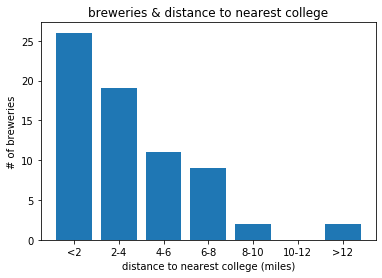

In [14]:
#distance bar chart thing; max 20.2, min 0ish, mean 3.89

#create bins & labels
dist_bins = [0, 2, 4, 6, 8, 10, 12, 25]
dist_labels = ['<2', '2-4', '4-6', '6-8', '8-10', '10-12', '>12']

#alternate bins
# dist_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# dist_labels = ['<1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11']

#categorize 'distance to C/U' data among bins, add to a new column
college_df2['distance to C/U (bin)'] = pd.cut (college_df2['distance to C/U (miles)'],
                                               dist_bins,
                                               labels = dist_labels,
                                               include_lowest = True)

#create series of # of colleges in each bin, plot in bar chart
dist_series = college_df2.groupby(['distance to C/U (bin)'])['name'].count()
plt.bar (dist_labels, dist_series)

#add axis labels & title
plt.xlabel ('distance to nearest college (miles)')
plt.ylabel ('# of breweries')
plt.title ('breweries & distance to nearest college')

#can alternatively use a box plot, or both
# college_df2['distance to C/U (miles)'].plot.box (grid = True)

#code for export here
plt.savefig ("output/college_bar_chart.png")

In [ ]:
#population demographics data, 1-2 images
#audrey

In [ ]:
#alternative ideas:
#establish date
#possible statistical test